<a href="https://colab.research.google.com/github/khalit7/distributional-semantics/blob/main/distributional_semantics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict,defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk import ngrams

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2,SelectPercentile

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [ ]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    prev_line = None
    prev_scene = None
    visited_scene_info = {} #  this is to keep track of scenes_info added for each character so as not to add the same scene more than once for each character
    for ind in df.index:
        line, name, scene,scene_info ,gender = df["Line"][ind], df["Character_name"][ind],df["Scene"][ind],df["Scene_info"][ind] ,df["Gender"][ind]
      
        if not name in character_docs.keys():
            character_docs[name] = ""
            visited_scene_info[name] = []
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        # add scene info
        if scene_info not in visited_scene_info[name]:
          character_docs[name] += " _BEGIN_SCENEINFO_ "+str(scene_info)   + " _END_SCENEINFO_ "
        # add previous line if in the same scene
        if prev_line != None and prev_scene == scene:
          character_docs[name] += " _BEGIN_PREVLINE_ "+str(prev_line)   + " _END_PREVLINE_ "
        # add current line
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        # add next line if it is in the same scene
        if ind+1 < len(df): # if there is a next line
           if df["Scene"][ind] == df.iloc[ind+1,1]: # id next line is in the same scene
            character_docs[name] += " _BEGIN_NEXTLINE_ "+str(df.iloc[ind+1,4])   + " _END_NEXTLINE_ "
        character_line_count[name]+=1
        prev_line = line
        prev_scene = scene
        visited_scene_info[name].append((scene_info))
    print("lines per character", character_line_count)
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  7968
OTHER Number of Words:  7303
JACK Number of Words:  8170
RONNIE Number of Words:  7866
TANYA Number of Words:  7702
SEAN Number of Words:  7320
ROXY Number of Words:  7602
HEATHER Number of Words:  7889
MAX Number of Words:  8285
IAN Number of Words:  8442
JANE Number of Words:  7826
STACEY Number of Words:  7497
PHIL Number of Words:  7860
MINTY Number of Words:  7738
CHRISTIAN Number of Words:  7547
CLARE Number of Words:  8166
total words 125181


In [ ]:
train_character_docs

{'CHRISTIAN': " _BEGIN_SCENEINFO_ FARGO'S INT NIGHT _END_SCENEINFO_  _BEGIN_PREVLINE_ Yeah, and can I point out that that's the millionth time you've said it? _END_PREVLINE_ Lesley! I'm really glad about this. You must be Ian. _EOL_  _BEGIN_PREVLINE_ Yeah. Hi. _END_PREVLINE_ This is my partner, Ashley. _EOL_  _BEGIN_PREVLINE_ Hi Asley, nice to meet you. Um, this is our table if you want to sit down. _END_PREVLINE_ What a lovely little place. _EOL_  _BEGIN_PREVLINE_ What a lovely little place. _END_PREVLINE_ So now that you've seen her in the flesh, Ashley, how does Lesley compare with the way I described her? _EOL_  _BEGIN_PREVLINE_ It's ‚Jane' nowadays, thank you Christian. _END_PREVLINE_ I keep on forgetting Lesley changed her name. What would your therapist bloke make of that? _EOL_  _BEGIN_PREVLINE_ I keep on forgetting Lesley changed her name. What would your therapist bloke make of that? _END_PREVLINE_ He might say it indicates an attempt to run away from something...But let's no

In [ ]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # remove punctuation except for underscore (because i want to keep _EOL_ as it is) #### i discovered that i can get better results if I keep the punctuation for latter
    # undesired_punc = (string.punctuation).replace("_","")+"‚"
    # character_text=character_text.translate(str.maketrans('', '',undesired_punc ))
    # tokanize the input
    tokens = character_text.split()   
    # stop words removal and lematization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # ps = PorterStemmer() #stemming gives worse results
    
    filtered_sentence = [lemmatizer.lemmatize(w) for w in tokens if not w.lower() in stop_words]
    return filtered_sentence

In [ ]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [ ]:
training_corpus[0][1]

['_BEGIN_SCENEINFO_',
 "FARGO'S",
 'INT',
 'NIGHT',
 '_END_SCENEINFO_',
 '_BEGIN_PREVLINE_',
 'Yeah,',
 'point',
 "that's",
 'millionth',
 'time',
 'said',
 'it?',
 '_END_PREVLINE_',
 'Lesley!',
 "I'm",
 'really',
 'glad',
 'this.',
 'must',
 'Ian.',
 '_EOL_',
 '_BEGIN_PREVLINE_',
 'Yeah.',
 'Hi.',
 '_END_PREVLINE_',
 'partner,',
 'Ashley.',
 '_EOL_',
 '_BEGIN_PREVLINE_',
 'Hi',
 'Asley,',
 'nice',
 'meet',
 'you.',
 'Um,',
 'table',
 'want',
 'sit',
 'down.',
 '_END_PREVLINE_',
 'lovely',
 'little',
 'place.',
 '_EOL_',
 '_BEGIN_PREVLINE_',
 'lovely',
 'little',
 'place.',
 '_END_PREVLINE_',
 'seen',
 'flesh,',
 'Ashley,',
 'Lesley',
 'compare',
 'way',
 'described',
 'her?',
 '_EOL_',
 '_BEGIN_PREVLINE_',
 "‚Jane'",
 'nowadays,',
 'thank',
 'Christian.',
 '_END_PREVLINE_',
 'keep',
 'forgetting',
 'Lesley',
 'changed',
 'name.',
 'would',
 'therapist',
 'bloke',
 'make',
 'that?',
 '_EOL_',
 '_BEGIN_PREVLINE_',
 'keep',
 'forgetting',
 'Lesley',
 'changed',
 'name.',
 'would',
 'ther

In [ ]:
train_labels

['CHRISTIAN',
 'CLARE',
 'HEATHER',
 'IAN',
 'JACK',
 'JANE',
 'MAX',
 'MINTY',
 'OTHER',
 'PHIL',
 'RONNIE',
 'ROXY',
 'SEAN',
 'SHIRLEY',
 'STACEY',
 'TANYA']

In [ ]:
sid = SentimentIntensityAnalyzer()
def sent_analysis(text):
  sent = sid.polarity_scores(text)
  del sent["compound"]
  sent = max(sent.keys(),key= lambda a :sent[a] )
  if sent == "pos":
    return "POSITIVE_SENT"
  if sent == "neg":
    return "NEGATIVE_SENT"
  if sent == "neu":
    return "NEUTRAL_SENT"


In [ ]:
def count_n_grams(all_sentences,n):
  return_value = defaultdict(int)
  for sentence in all_sentences:
    n_grams = ngrams(sentence, n,pad_left=True,pad_right=True,left_pad_symbol="<s>",right_pad_symbol="</s>")
    fdist = nltk.FreqDist(n_grams)
    fdist = dict(fdist)
    for k,v in fdist.items():
      return_value[k] +=v
  return return_value

In [ ]:
def get_pos_tag(tokanized_text):
  pos = nltk.pos_tag(tokanized_text)
  ans = list(map(lambda x : x[0]+"@"+x[1],pos))
  return ans

In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    counts = defaultdict(int)

    all_sentences = []
    sentence = []
    process_scene_info = False
    process_previous_line = False
    process_next_line = False
    for word in character_doc:

      # determine which to process
      if word == "_BEGIN_SCENEINFO_":
        process_scene_info = True
        continue
      if word == "_BEGIN_PREVLINE_":
        process_previous_line = True
        continue
      if word == "_BEGIN_NEXTLINE_":
        process_next_line = True
        continue
      if word == "_END_SCENEINFO_":
        process_scene_info = False
        continue
      if word == "_END_PREVLINE_":
        process_previous_line = False
        continue
      if word == "_END_NEXTLINE_":
        process_next_line = False
        continue

      if process_previous_line:
        counts["prev_"+word]+=1
        continue
      if process_scene_info:
        counts["scene_"+word]+=1
        continue
      if process_next_line:
        counts["next_"+word]+=1
        continue

      # if we are here that means we are processing current line

      if word == "_EOL_":
        # sentiment analysis
        # extra_features.append(sent_analysis(" ".join(sentence))) # sentiment analysis gave worse results

        # pos tag
        sentence_pos_tag = get_pos_tag(sentence)
        extra_features.extend(sentence_pos_tag)

        all_sentences.append(sentence)
        sentence = []
        continue
      if word[-1] in string.punctuation:
        if len(word[:-1])>0: # the punctuation is the last character in a word eg: "lesily!" # in this case dont include the punctuation in the features
          word = word[:-1]
        # else the punctuation is outside a word. eg: "?" # in this case include the punctuation in the features
      sentence.append(word)
      counts[word] +=1

      # has number
      if re.search(_pattern, word) is not None:
        extra_features.append("HAS_NUM")

      


    for feature in extra_features:
        counts[feature] += 1

    # three grams
    three_grams = count_n_grams(all_sentences,3)
    for k,v in three_grams.items():
      counts[k[0]+" "+k[1]+" "+k[2]] = v
    # two grams
    two_grams = count_n_grams(all_sentences,2)
    for k,v in two_grams.items():
      counts[k[0]+" "+k[1]] = v

    return counts  

In [ ]:
x=[to_feature_vector_dictionary(doc,extra_features=[]) for name, doc in training_corpus]

In [ ]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusTransformer = TfidfTransformer()

best_features_selection = SelectPercentile(chi2, percentile=6) # I got this value after trying all values (from 1 to 99) using the code block in Q2.

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    to_vectorize = [to_feature_vector_dictionary(doc,extra_features=[]) for name, doc in corpus]
    if fitting:
        corpusVectorizer.fit(to_vectorize)
    doc_feature_matrix = corpusVectorizer.transform(to_vectorize)


    # select best k% features
    if fitting:
      doc_feature_matrix = best_features_selection.fit_transform(doc_feature_matrix, train_labels)
    else:
      doc_feature_matrix = best_features_selection.transform(doc_feature_matrix)

    # tfidf trnsformer
    if fitting:
      corpusTransformer.fit(doc_feature_matrix)
    doc_feature_matrix = corpusTransformer.transform(doc_feature_matrix)

    #
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [ ]:
training_feature_matrix.shape

(16, 4706)

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  901
MAX Num of Words:  1179
SEAN Num of Words:  703
SHIRLEY Num of Words:  806
OTHER Num of Words:  696
STACEY Num of Words:  860
RONNIE Num of Words:  913
JACK Num of Words:  766
PHIL Num of Words:  910
IAN Num of Words:  927
JANE Num of Words:  1000
ROXY Num of Words:  885
HEATHER Num of Words:  811
MINTY Num of Words:  981
CHRISTIAN Num of Words:  999
CLARE Num of Words:  1008
total words 14345


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [ ]:
val_feature_matrix.shape

(16, 4706)

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.0
mean cosine similarity 0.4211813128870381
16 correct out of 16 / accuracy: 1.0


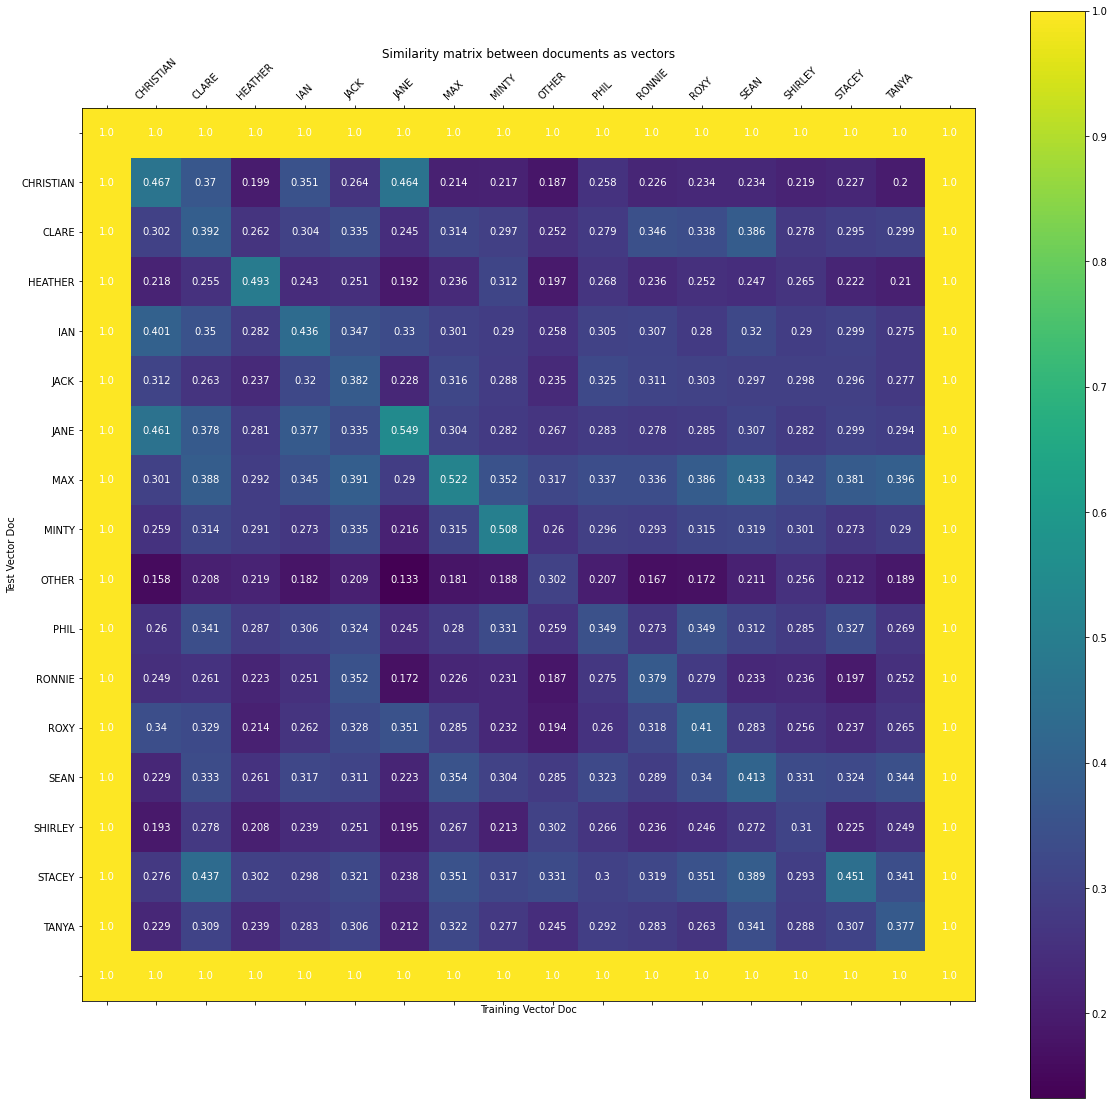

In [ ]:
plot_heat_map_similarity(df)

In [ ]:
'''
This code block is used whenever I add new features to help me determine many k% features should I use.
un comment if you feel the need to test it
'''
# mean_rank_arr=[]
# for p in range(1,100):
#   print("percentile = {}%".format(p))
#   best_features_selection = SelectPercentile(chi2, percentile=p)

#   training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
#   val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
#   mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
#   mean_rank_arr.append(mean_rank)

percentile = 1%
mean rank 1.25
mean cosine similarity 0.5451154718323107
13 correct out of 16 / accuracy: 0.8125
percentile = 2%
mean rank 1.125
mean cosine similarity 0.507566981967458
14 correct out of 16 / accuracy: 0.875
percentile = 3%
mean rank 1.125
mean cosine similarity 0.4719947994253551
14 correct out of 16 / accuracy: 0.875
percentile = 4%
mean rank 1.125
mean cosine similarity 0.4445914081179828
14 correct out of 16 / accuracy: 0.875
percentile = 5%
mean rank 1.0625
mean cosine similarity 0.42751734778367234
15 correct out of 16 / accuracy: 0.9375
percentile = 6%
mean rank 1.0
mean cosine similarity 0.4211813128870381
16 correct out of 16 / accuracy: 1.0
percentile = 7%
mean rank 1.0
mean cosine similarity 0.413729844106398
16 correct out of 16 / accuracy: 1.0
percentile = 8%
mean rank 1.0625
mean cosine similarity 0.4105232833872009
15 correct out of 16 / accuracy: 0.9375
percentile = 9%
mean rank 1.0625
mean cosine similarity 0.4049728600999987
15 correct out of 16 / acc

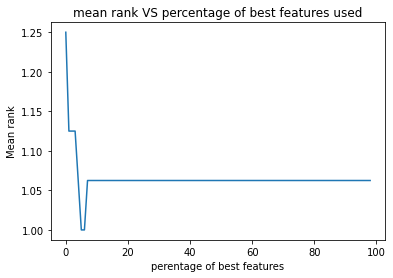

1.0
1.0


In [ ]:
# plt.title("mean rank VS percentage of best features used")
# plt.xlabel("perentage of best features")
# plt.ylabel("Mean rank")
# plt.plot(mean_rank_arr)
# plt.show()
# print(min(mean_rank_arr))

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusTransformer = TfidfTransformer()
best_features_selection = SelectPercentile(chi2, percentile=6) # I got this value after trying all values (from 1 to 99) using the code block in Q2.


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  12412
OTHER Number of Words:  10631
JACK Number of Words:  12500
RONNIE Number of Words:  13059
TANYA Number of Words:  12215
SEAN Number of Words:  12141
ROXY Number of Words:  12449
HEATHER Number of Words:  13127
MAX Number of Words:  13495
IAN Number of Words:  13592
JANE Number of Words:  12933
STACEY Number of Words:  12419
PHIL Number of Words:  13330
MINTY Number of Words:  13243
CHRISTIAN Number of Words:  12511
CLARE Number of Words:  13297
total words 203354
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
N

# From here down words, I will log my results as multi line comments


#Q1

## Before improving anything (baseline)

In [ ]:
'''
mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25
'''

'\nmean rank 4.5\nmean cosine similarity 0.9128136458100018\n4 correct out of 16 / accuracy: 0.25\n'

# adding stop words removal

In [ ]:
'''
mean rank 2.875
mean cosine similarity 0.9369644543954785
11 correct out of 16 / accuracy: 0.6875
'''

'\nmean rank 2.875\nmean cosine similarity 0.9369644543954785\n11 correct out of 16 / accuracy: 0.6875\n'

# removing punctuation

In [ ]:
'''
mean rank 2.625
mean cosine similarity 0.9376700418183526
9 correct out of 16 / accuracy: 0.5625
'''

'\nmean rank 2.625\nmean cosine similarity 0.9376700418183526\n9 correct out of 16 / accuracy: 0.5625\n'

## used lemmatization (without pos tagging)..... BEST IN Q1

In [ ]:
'''
mean rank 2.4375
mean cosine similarity 0.9374309480568137
9 correct out of 16 / accuracy: 0.5625
'''

'\nmean rank 2.4375\nmean cosine similarity 0.9374309480568137\n9 correct out of 16 / accuracy: 0.5625\n'

## previous config.. but converting all words to lowe case

In [ ]:
'''
mean rank 2.6875
mean cosine similarity 0.9370974035006285
8 correct out of 16 / accuracy: 0.5
'''

'\nmean rank 2.6875\nmean cosine similarity 0.9370974035006285\n8 correct out of 16 / accuracy: 0.5\n'

# Q2

## BEST IN Q1 + removing _EOL_ from the count. BEST SO FAR

In [ ]:
'''
mean rank 1.625
mean cosine similarity 0.550172157151589
11 correct out of 16 / accuracy: 0.6875
'''

'\nmean rank 1.625\nmean cosine similarity 0.550172157151589\n11 correct out of 16 / accuracy: 0.6875\n'

#best so far + tried 2 grams only

In [ ]:
'''
mean rank 1.5
mean cosine similarity 0.476744775262554
9 correct out of 16 / accuracy: 0.5625
'''

'\nmean rank 1.5\nmean cosine similarity 0.476744775262554\n9 correct out of 16 / accuracy: 0.5625\n'

#best so far + tried 3 grams only (without 2 grams)

In [ ]:
'''
mean rank 1.5625
mean cosine similarity 0.4846353781274749
8 correct out of 16 / accuracy: 0.5
'''

'\nmean rank 1.5625\nmean cosine similarity 0.4846353781274749\n8 correct out of 16 / accuracy: 0.5\n'

# now tried both 2 grams and 3 grams BEST SO FAR!

In [ ]:
'''
mean rank 1.5
mean cosine similarity 0.4411271567742432
10 correct out of 16 / accuracy: 0.625
'''
# notice that it is giving the same as the best mean rank but better accuracy.

'\nmean rank 1.5\nmean cosine similarity 0.4411271567742432\n10 correct out of 16 / accuracy: 0.625\n'

# used best so far + I added pos tags in the form word@postag BEST SO FAR!

In [ ]:
'''
mean rank 1.375
mean cosine similarity 0.5133006345178202
12 correct out of 16 / accuracy: 0.75
'''

'\nmean rank 1.375\nmean cosine similarity 0.5133006345178202\n12 correct out of 16 / accuracy: 0.75\n'

#used best so far + counted the number of times there is a number (HAS_NUM)

In [ ]:
'''
mean rank 1.375
mean cosine similarity 0.5133006345178202
12 correct out of 16 / accuracy: 0.75
''' 
#even though there is no improvement, i decided to keep the feature anyways as I am plannining to use selectKbest which will include this feature if it was usefull and discard it if it is not

'\nmean rank 1.375\nmean cosine similarity 0.5133006345178202\n12 correct out of 16 / accuracy: 0.75\n'

# used previous configuration + counted the number of positive and negative sentiments

In [ ]:
'''

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
mean rank 1.6875
mean cosine similarity 0.49976351863605795
9 correct out of 16 / accuracy: 0.5625
'''

'\n\nmean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)\nmean rank 1.6875\nmean cosine similarity 0.49976351863605795\n9 correct out of 16 / accuracy: 0.5625\n'

#used best configuration + HAS_NUM. and selected the best k% feature, i used 20 % of the data after testing all values from 1% to 99% (look at the code block in the Q2 section) BEST SO FAR

In [ ]:
'''
mean rank 1.3125
mean cosine similarity 0.5215599020684505
13 correct out of 16 / accuracy: 0.8125
'''

'\nmean rank 1.3125\nmean cosine similarity 0.5215599020684505\n13 correct out of 16 / accuracy: 0.8125\n'

#Q3

## added the previous line + scene info with k = 7% BEST SO FAR !

In [ ]:
'''
mean rank 1.0625
mean cosine similarity 0.42931675533837266
15 correct out of 16 / accuracy: 0.9375
'''

'\nmean rank 1.0625\nmean cosine similarity 0.42931675533837266\n15 correct out of 16 / accuracy: 0.9375\n'

##added bext line with k = 7%

In [ ]:
'''
mean rank 1.0625
mean cosine similarity 0.43140471427972693
15 correct out of 16 / accuracy: 0.9375
'''

'\nmean rank 1.0625\nmean cosine similarity 0.43140471427972693\n15 correct out of 16 / accuracy: 0.9375\n'

#Q4

## using best so far + tfidf with k=7%

In [ ]:
'''
mean rank 1.0625
mean cosine similarity 0.43228201111846554
15 correct out of 16 / accuracy: 0.9375
''' # even though it gave simillar results to BEST SO FAR  i decided to keep it because looking at the confusino matrix, there was a better seperation which will mean better generalization

'\nmean rank 1.0625\nmean cosine similarity 0.43228201111846554\n15 correct out of 16 / accuracy: 0.9375\n'

#further trials

I added char _ from the previous line with k = 6%

In [ ]:
'''
mean rank 1.0
mean cosine similarity 0.4211813128870381
16 correct out of 16 / accuracy: 1.0
'''